In [3]:
# 1MBA (myoglobin)
#seq = "SLSAAEADLAGKSWAPVFANKNANGLDFLVALFEKFPDSANFFADFKGKSVADIKASPKLRDVSSRIFTRLNEFVNNAANAGKMSAMLSQFAKEHVGFGVGSAQFENVRSMFPGFVASVAAPPAGADAAWTKLFGLIIDALKAAGA"

# 1MJC
seq = "SGKMTGIVKWFNADKGFGFITPDDGSKDVFVHFSAIQNDGYKSLDEGQKVSFTIESGAKGPAAGNVTSL"

with open("ss.a3m", "w") as f:
    f.write(f">test\n{seq}\n")

header = f"test|protein|ss.a3m"

with open("ss.fasta", "w") as f:
    f.write(f">{header}\n{seq}\n")



In [4]:
num_samples = 64
%run /home/gridsan/jroney/solab/af3/FoldScaling/boltz/src/boltz/main.py predict ss.fasta --diffusion_samples {num_samples} --recycling_steps 0 --override --skip_pred --sampling_steps 100


Checking input data.
Found existing predictions, will override.
Running predictions for 1 structure
Processing input data.
Found a manifest file at output directory: boltz_results_ss
All examples in data are processed. Updating the manifest


/home/gridsan/jroney/.conda/envs/boltz1/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3.11 /home/gridsan/jroney/solab/af3/FoldScaling/boltz ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Skipping prediction step as requested.


/home/gridsan/jroney/.conda/envs/boltz1/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


In [5]:
processed = _boltz_inputs
data_module = BoltzInferenceDataModule(
    manifest=processed.manifest,
    target_dir=processed.targets_dir,
    msa_dir=processed.msa_dir,
    num_workers=1,
    constraints_dir=processed.constraints_dir,
)

batch = next(iter(data_module.predict_dataloader()))
batch = {k:v.cuda() if torch.is_tensor(v) else v for k,v in batch.items()}
model = _boltz_module.cuda()

In [6]:
trunk_out = model(
        batch,
        recycling_steps=model.predict_args["recycling_steps"],
        num_sampling_steps=model.predict_args["sampling_steps"],
        diffusion_samples=num_samples,
        return_final_reps=True,
        skip_diffusion=True)

In [7]:
diff_outputs = model.structure_module.sample(
                    s_trunk=trunk_out['s_trunk'],
                    z_trunk=trunk_out['z_trunk'],
                    s_inputs=trunk_out['s_inputs'],
                    feats=trunk_out['feats'],
                    relative_position_encoding=trunk_out['relative_position_encoding'],
                    num_sampling_steps=model.predict_args["sampling_steps"],
                    atom_mask=trunk_out['feats']["atom_pad_mask"],
                    multiplicity=num_samples,
                    train_accumulate_token_repr=model.training,
                    steering_args={'fk_steering' : False, 'guidance_update': False},
                    custom_noise=None,
                    custom_potentials=[]
                )

In [8]:
model.confidence_module.use_s_diffusion=False
conf_out = model.confidence_module(
        s_inputs=trunk_out['s_trunk'],
        s=trunk_out['s_trunk'],
        z=trunk_out['z_trunk'],
        s_diffusion=None,
        x_pred=diff_outputs['sample_atom_coords'],
        feats=trunk_out['feats'],
        pred_distogram_logits=trunk_out["pdistogram"],
        multiplicity=model.predict_args["diffusion_samples"],
        run_sequentially=False
    )

(array([ 2.,  3.,  5.,  5.,  2.,  6.,  8., 22.,  9.,  2.]),
 array([0.40894899, 0.41841182, 0.42787465, 0.43733749, 0.44680032,
        0.45626318, 0.46572602, 0.47518885, 0.48465168, 0.49411452,
        0.50357735]),
 <BarContainer object of 10 artists>)

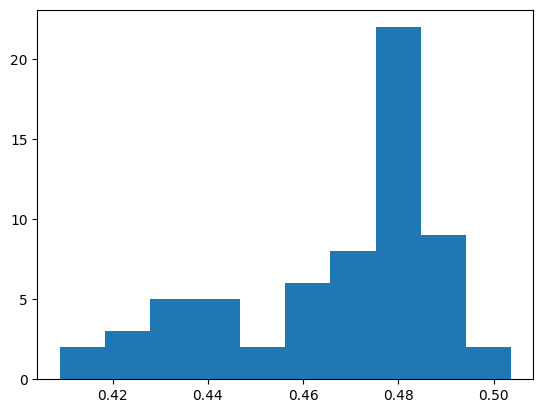

In [9]:
import matplotlib.pyplot as plt

conf_score = (4*conf_out['complex_plddt'] + conf_out['ptm']).cpu().numpy() /5
plt.hist(conf_score)

In [10]:
from boltz.model.potentials.potentials import Potential

"""
Class for FK guidance with confidence module as guiding potential
"""

model.steering_args['num_particles']=8
model.steering_args['fk_lambda']=50
model.steering_args['fk_resampling_interval']=5
model.steering_args['guidance_update']=False
model.steering_args['max_fk_noise'] = 100
model.steering_args['potential_type'] = "vanilla"
model.steering_args['noise_coord_potential'] = False

class BoltzConfidencePotential(Potential):

    def compute_args(self, feats, params):
        return None, (), None # dummy return vals
    
    def compute_variable(self, coords, index, compute_gradient=False):

            
        conf_out = model.confidence_module(
                s_inputs=trunk_out['s_trunk'],
                s=trunk_out['s_trunk'],
                z=trunk_out['z_trunk'],
                s_diffusion=None,
                x_pred=coords,
                feats=trunk_out['feats'],
                pred_distogram_logits=trunk_out["pdistogram"],
                multiplicity=model.predict_args["diffusion_samples"] * model.steering_args['num_particles'],
                run_sequentially=False
            )

        conf_score = (4*conf_out['complex_plddt'] + conf_out['ptm']) / 5
        conf_score = conf_score.unsqueeze(-1) # this is important because it expects the energy to have many contributions from different indices

        print(conf_score)
        if not compute_gradient:
            return conf_score

        return conf_score, torch.zeros_like(coords) # we can't get a gradient because the prediction is turned into a binned dgram
        
    # def compute_function(self, value, compute_derivative=False):
    #     nrg = -torch.log(value)
    #     if not compute_derivative:
    #         return nrg
        
    #     return nrg, -1/nrg

    def compute_function(self, value, compute_derivative=False):
        nrg = 1-value
        if not compute_derivative:
            return nrg
        
        return nrg, -value

        
        

In [11]:
pot = BoltzConfidencePotential(parameters={
                'guidance_interval': 5,
                'guidance_weight': 0.00,
                'resampling_weight': 1.0,
            })

In [12]:
model.steering_args

{'fk_steering': True,
 'num_particles': 8,
 'fk_lambda': 50,
 'fk_resampling_interval': 5,
 'guidance_update': False,
 'num_gd_steps': 16,
 'max_fk_noise': 100,
 'potential_type': 'vanilla',
 'noise_coord_potential': False}

In [13]:
diff_outputs_guided = model.structure_module.sample(
                        s_trunk=trunk_out['s_trunk'],
                        z_trunk=trunk_out['z_trunk'],
                        s_inputs=trunk_out['s_inputs'],
                        feats=trunk_out['feats'],
                        relative_position_encoding=trunk_out['relative_position_encoding'],
                        num_sampling_steps=model.predict_args["sampling_steps"],
                        atom_mask=trunk_out['feats']["atom_pad_mask"],
                        multiplicity=num_samples,
                        train_accumulate_token_repr=model.training,
                        steering_args=model.steering_args,
                        custom_noise=None,
                        custom_potentials=[pot]
                    )

61.93838119506836
tensor([[0.4532],
        [0.4785],
        [0.4843],
        [0.4748],
        [0.4651],
        [0.4714],
        [0.4754],
        [0.4815],
        [0.4607],
        [0.4437],
        [0.4703],
        [0.4818],
        [0.4790],
        [0.4514],
        [0.4847],
        [0.4789],
        [0.4760],
        [0.4825],
        [0.4692],
        [0.4846],
        [0.4801],
        [0.4579],
        [0.4845],
        [0.4823],
        [0.4788],
        [0.4789],
        [0.4690],
        [0.4862],
        [0.4895],
        [0.4853],
        [0.4767],
        [0.4796],
        [0.4611],
        [0.4653],
        [0.4797],
        [0.4893],
        [0.4836],
        [0.4831],
        [0.4758],
        [0.4838],
        [0.4893],
        [0.4796],
        [0.4714],
        [0.4782],
        [0.4724],
        [0.4728],
        [0.4783],
        [0.4682],
        [0.4816],
        [0.4716],
        [0.4856],
        [0.4862],
        [0.4868],
        [0.4911],
        [0

In [15]:
conf_out_guided = model.confidence_module(
        s_inputs=trunk_out['s_trunk'],
        s=trunk_out['s_trunk'],
        z=trunk_out['z_trunk'],
        s_diffusion=None,
        x_pred=diff_outputs_guided['sample_atom_coords'],
        feats=trunk_out['feats'],
        pred_distogram_logits=trunk_out["pdistogram"],
        multiplicity=model.predict_args["diffusion_samples"],
        run_sequentially=False
    )

(array([ 2.,  5.,  6.,  8., 17.,  6., 11.,  5.,  0.,  4.]),
 array([0.46646237, 0.47160044, 0.47673851, 0.48187661, 0.48701468,
        0.49215275, 0.49729082, 0.50242889, 0.50756699, 0.51270503,
        0.51784313]),
 <BarContainer object of 10 artists>)

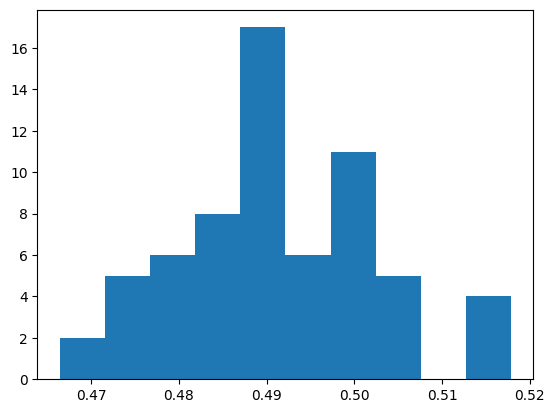

In [16]:
conf_score = (4*conf_out_guided['complex_plddt'] + conf_out_guided['ptm']).cpu().numpy() /5
plt.hist(conf_score)

(array([ 2.,  3.,  5.,  5.,  2.,  6.,  8., 22.,  9.,  2.]),
 array([0.40894899, 0.41841182, 0.42787465, 0.43733749, 0.44680032,
        0.45626318, 0.46572602, 0.47518885, 0.48465168, 0.49411452,
        0.50357735]),
 <BarContainer object of 10 artists>)

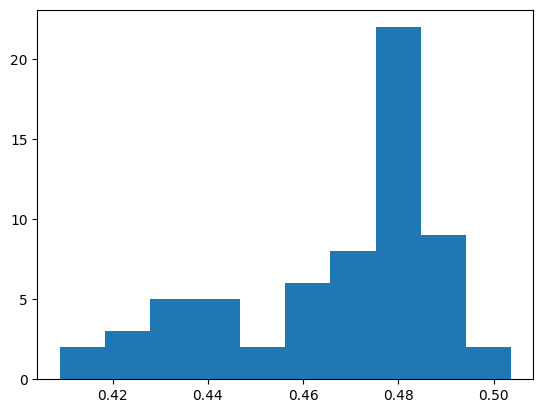

In [17]:
conf_score = (4*conf_out['complex_plddt'] + conf_out['ptm']).cpu().numpy() / 5
plt.hist(conf_score)

In [18]:
conf_out['complex_plddt']

tensor([0.5549, 0.5700, 0.5488, 0.4739, 0.5487, 0.5293, 0.5411, 0.5396, 0.5429,
        0.5451, 0.5558, 0.4820, 0.4884, 0.4892, 0.5349, 0.5219, 0.5451, 0.5476,
        0.5429, 0.5391, 0.5033, 0.5115, 0.5634, 0.5605, 0.5152, 0.5229, 0.5455,
        0.4917, 0.5413, 0.5249, 0.4988, 0.5470, 0.5519, 0.5278, 0.5451, 0.4958,
        0.5083, 0.5456, 0.5394, 0.5394, 0.5517, 0.5490, 0.5491, 0.5394, 0.5409,
        0.5447, 0.5219, 0.4767, 0.5575, 0.5450, 0.5258, 0.5509, 0.5405, 0.5340,
        0.5388, 0.5119, 0.5320, 0.5465, 0.5059, 0.5434, 0.5004, 0.5235, 0.5408,
        0.4971], device='cuda:0')

In [19]:
conf_out_guided['complex_plddt']

tensor([0.5453, 0.5426, 0.5680, 0.5627, 0.5696, 0.5601, 0.5609, 0.5580, 0.5284,
        0.5593, 0.5585, 0.5388, 0.5557, 0.5832, 0.5462, 0.5370, 0.5443, 0.5591,
        0.5610, 0.5491, 0.5483, 0.5543, 0.5537, 0.5593, 0.5587, 0.5629, 0.5536,
        0.5580, 0.5458, 0.5864, 0.5568, 0.5807, 0.5651, 0.5530, 0.5689, 0.5523,
        0.5579, 0.5665, 0.5516, 0.5687, 0.5483, 0.5379, 0.5670, 0.5583, 0.5497,
        0.5727, 0.5330, 0.5844, 0.5611, 0.5395, 0.5346, 0.5476, 0.5671, 0.5628,
        0.5310, 0.5560, 0.5622, 0.5482, 0.5557, 0.5471, 0.5725, 0.5560, 0.5666,
        0.5719], device='cuda:0')

In [26]:
model.structure_module.num_sampling_steps

5